# Text-Conditioned Segmentation for Construction Inspection

## Dataset Overview

- **Cracks**: Instance segmentation (polygon masks) ✅
- **Drywall**: Object detection (bounding boxes) - converted to masks
  - 820 training images
  - 1,100 bounding boxes total (avg 1.34 boxes/image)
  - 188 images have multiple boxes (2-5 per image)
  
**Prompts**:
- `"segment crack"` → Detect cracks
- `"segment taping area"` → Detect drywall taping regions

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Simple Text Tokenizer

In [16]:
class SimpleTokenizer:
    """Simple word-based tokenizer for text prompts"""
    def __init__(self):
        self.vocab = {
            '[PAD]': 0, '[UNK]': 1,
            'segment': 2, 'crack': 3, 'taping': 4, 'area': 5
        }
        self.max_len = 4
    
    def encode(self, text):
        """Convert text to token IDs"""
        tokens = text.lower().split()
        ids = [self.vocab.get(t, self.vocab['[UNK]']) for t in tokens]
        # Pad or truncate
        if len(ids) < self.max_len:
            ids += [self.vocab['[PAD]']] * (self.max_len - len(ids))
        return torch.tensor(ids[:self.max_len], dtype=torch.long)
    
    @property
    def vocab_size(self):
        return len(self.vocab)

tokenizer = SimpleTokenizer()
print(f"Vocabulary: {tokenizer.vocab}")
print(f"Vocab size: {tokenizer.vocab_size}")

Vocabulary: {'[PAD]': 0, '[UNK]': 1, 'segment': 2, 'crack': 3, 'taping': 4, 'area': 5}
Vocab size: 6


Dataset with Augmentation

In [17]:
class SegmentationDataset(Dataset):
    """Dataset for text-conditioned segmentation"""
    
    def __init__(self, root_dir, split='train', img_size=256, augment=False):
        self.root = Path(root_dir) / split
        self.augment = augment
        
        # Find all masks
        mask_dir = self.root / 'masks'
        self.samples = []
        
        for mask_path in mask_dir.glob('*.png'):
            # Parse filename: base_name__prompt.png
            parts = mask_path.stem.split('__')
            if len(parts) != 2:
                continue
            
            base_name, prompt = parts
            # Find corresponding image
            img_path = self.root / 'images' / f"{base_name}.jpg"
            
            if img_path.exists():
                self.samples.append({
                    'image': str(img_path),
                    'mask': str(mask_path),
                    'prompt': prompt.replace('_', ' ')  # "segment_crack" -> "segment crack"
                })
        
        # Transforms
        self.img_transform = T.Compose([
            T.ToPILImage(),
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.mask_transform = T.Compose([
            T.ToPILImage(),
            T.Resize((img_size, img_size)),
            T.ToTensor()
        ])
        
        # Augmentation (for training only)
        self.aug_transform = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(10),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
        ])
        
        print(f"{split}: {len(self.samples)} samples loaded")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image and mask
        image = cv2.imread(sample['image'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(sample['mask'], cv2.IMREAD_GRAYSCALE)
        
        # Apply augmentation if training
        if self.augment:
            # Convert to PIL for augmentation
            from PIL import Image
            image_pil = Image.fromarray(image)
            mask_pil = Image.fromarray(mask)
            
            # Apply same random transform to both
            seed = np.random.randint(2147483647)
            torch.manual_seed(seed)
            image_pil = self.aug_transform(image_pil)
            torch.manual_seed(seed)
            mask_pil = self.aug_transform(mask_pil)
            
            image = np.array(image_pil)
            mask = np.array(mask_pil)
        
        # Apply transforms
        image = self.img_transform(image)
        mask = self.mask_transform(mask)
        
        # Tokenize prompt
        tokens = tokenizer.encode(sample['prompt'])
        
        return image, mask, tokens, sample['prompt']

Create Dataloaders

In [18]:
# Hyperparameters
IMG_SIZE = 256
BATCH_SIZE = 16
NUM_WORKERS = 4

# Create datasets
train_dataset = SegmentationDataset('final_dataset', split='train', img_size=IMG_SIZE, augment=True)
valid_dataset = SegmentationDataset('final_dataset', split='valid', img_size=IMG_SIZE, augment=False)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"\nDataloaders ready:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(valid_loader)}")

train: 5984 samples loaded
valid: 403 samples loaded

Dataloaders ready:
  Training batches: 374
  Validation batches: 26


 Text-Conditioned U-Net Model

Architecture:
- U-Net encoder-decoder structure
- FiLM (Feature-wise Linear Modulation) layers for text conditioning
- Dropout and BatchNorm for regularization

In [19]:
class FiLMLayer(nn.Module):
    """Feature-wise Linear Modulation for text conditioning"""
    def __init__(self, text_dim, feature_dim):
        super().__init__()
        self.gamma = nn.Linear(text_dim, feature_dim)
        self.beta = nn.Linear(text_dim, feature_dim)
    
    def forward(self, features, text_embedding):
        # features: (B, C, H, W)
        # text_embedding: (B, text_dim)
        gamma = self.gamma(text_embedding).unsqueeze(2).unsqueeze(3)  # (B, C, 1, 1)
        beta = self.beta(text_embedding).unsqueeze(2).unsqueeze(3)
        return gamma * features + beta


class TextConditionedUNet(nn.Module):
    """U-Net with text conditioning via FiLM layers"""
    
    def __init__(self, vocab_size, embed_dim=32, text_dim=64, channels=[16, 32, 64], dropout=0.2):
        super().__init__()
        
        # Text embedding
        self.text_embedding = nn.Embedding(vocab_size, embed_dim)
        self.text_encoder = nn.Sequential(
            nn.Linear(embed_dim * 4, text_dim),  # 4 = max sequence length
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Encoder
        self.enc1 = self._conv_block(3, channels[0], dropout)
        self.film1 = FiLMLayer(text_dim, channels[0])
        
        self.enc2 = self._conv_block(channels[0], channels[1], dropout)
        self.film2 = FiLMLayer(text_dim, channels[1])
        
        self.enc3 = self._conv_block(channels[1], channels[2], dropout)
        self.film3 = FiLMLayer(text_dim, channels[2])
        
        # Bottleneck
        self.bottleneck = self._conv_block(channels[2], channels[2], dropout)
        self.film_bottleneck = FiLMLayer(text_dim, channels[2])
        
        # Decoder
        self.upconv3 = nn.ConvTranspose2d(channels[2], channels[2], 2, 2)
        self.dec3 = self._conv_block(channels[2] * 2, channels[1], dropout)
        
        self.upconv2 = nn.ConvTranspose2d(channels[1], channels[1], 2, 2)
        self.dec2 = self._conv_block(channels[1] * 2, channels[0], dropout)
        
        self.upconv1 = nn.ConvTranspose2d(channels[0], channels[0], 2, 2)
        self.dec1 = self._conv_block(channels[0] * 2, channels[0], dropout)
        
        # Output
        self.output = nn.Conv2d(channels[0], 1, 1)
    
    def _conv_block(self, in_ch, out_ch, dropout):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x, text_tokens):
        # Encode text
        text_embed = self.text_embedding(text_tokens)  # (B, seq_len, embed_dim)
        text_embed = text_embed.flatten(1)  # (B, seq_len * embed_dim)
        text_features = self.text_encoder(text_embed)  # (B, text_dim)
        
        # Encoder with FiLM conditioning
        e1 = self.enc1(x)
        e1 = self.film1(e1, text_features)
        p1 = F.max_pool2d(e1, 2)
        
        e2 = self.enc2(p1)
        e2 = self.film2(e2, text_features)
        p2 = F.max_pool2d(e2, 2)
        
        e3 = self.enc3(p2)
        e3 = self.film3(e3, text_features)
        p3 = F.max_pool2d(e3, 2)
        
        # Bottleneck
        b = self.bottleneck(p3)
        b = self.film_bottleneck(b, text_features)
        
        # Decoder with skip connections
        d3 = self.upconv3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        # Output
        out = self.output(d1)
        return out

 Initialize Model

In [20]:
# Create model
model = TextConditionedUNet(
    vocab_size=tokenizer.vocab_size,
    embed_dim=32,
    text_dim=64,
    channels=[16, 32, 64],
    dropout=0.2
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print(f"\nOptimization setup:")
print(f"  Loss: Binary Cross Entropy with Logits")
print(f"  Optimizer: Adam (lr=1e-3, weight_decay=1e-4)")
print(f"  Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)")

Model initialized:
  Total parameters: 264,497
  Trainable parameters: 264,497

Optimization setup:
  Loss: Binary Cross Entropy with Logits
  Optimizer: Adam (lr=1e-3, weight_decay=1e-4)
  Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)


Training Functions

In [21]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, masks, tokens, _ in pbar:
        images = images.to(device)
        masks = masks.to(device)
        tokens = tokens.to(device)
        
        # Forward pass
        outputs = model(images, tokens)
        loss = criterion(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader)


def validate(model, loader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, masks, tokens, _ in pbar:
            images = images.to(device)
            masks = masks.to(device)
            tokens = tokens.to(device)
            
            outputs = model(images, tokens)
            loss = criterion(outputs, masks)
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader)

Training Loop with Early Stopping

In [22]:
# Training configuration
NUM_EPOCHS = 20
EARLY_STOP_PATIENCE = 10
BEST_MODEL_PATH = 'best_model.pth'

# Training history
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print(f"Starting training for {NUM_EPOCHS} epochs...\n")

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, valid_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Update learning rate
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  LR:         {current_lr:.6f}")
    
    # Save best model
    if val_loss < best_val_loss:
        improvement = best_val_loss - val_loss
        best_val_loss = val_loss
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, BEST_MODEL_PATH)
        
        print(f"  ✅ Best model saved! (improved by {improvement:.4f})")
    else:
        patience_counter += 1
        print(f"  ⏳ No improvement ({patience_counter}/{EARLY_STOP_PATIENCE})")
    
    # Early stopping
    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"\n⛔ Early stopping triggered at epoch {epoch+1}")
        print(f"   Best validation loss: {best_val_loss:.4f}")
        break

print(f"\n{'='*60}")
print("Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"{'='*60}")

Starting training for 20 epochs...


Epoch 1/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.67it/s, loss=0.3942]




Epoch 1 Summary:
  Train Loss: 0.2701
  Val Loss:   0.2982
  LR:         0.001000
  ✅ Best model saved! (improved by inf)

Epoch 2/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 19.94it/s, loss=0.3765]




Epoch 2 Summary:
  Train Loss: 0.1794
  Val Loss:   0.2898
  LR:         0.001000
  ✅ Best model saved! (improved by 0.0085)

Epoch 3/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 19.45it/s, loss=0.3784]



Epoch 3 Summary:
  Train Loss: 0.1696
  Val Loss:   0.2901
  LR:         0.001000
  ⏳ No improvement (1/10)

Epoch 4/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 19.58it/s, loss=0.3825]




Epoch 4 Summary:
  Train Loss: 0.1627
  Val Loss:   0.2791
  LR:         0.001000
  ✅ Best model saved! (improved by 0.0107)

Epoch 5/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 19.10it/s, loss=0.3808]




Epoch 5 Summary:
  Train Loss: 0.1545
  Val Loss:   0.2694
  LR:         0.001000
  ✅ Best model saved! (improved by 0.0097)

Epoch 6/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 19.21it/s, loss=0.3461]




Epoch 6 Summary:
  Train Loss: 0.1493
  Val Loss:   0.2479
  LR:         0.001000
  ✅ Best model saved! (improved by 0.0215)

Epoch 7/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 19.81it/s, loss=0.3429]




Epoch 7 Summary:
  Train Loss: 0.1480
  Val Loss:   0.2445
  LR:         0.001000
  ✅ Best model saved! (improved by 0.0034)

Epoch 8/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 20.24it/s, loss=0.3352]




Epoch 8 Summary:
  Train Loss: 0.1458
  Val Loss:   0.2434
  LR:         0.001000
  ✅ Best model saved! (improved by 0.0011)

Epoch 9/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 19.94it/s, loss=0.3415]




Epoch 9 Summary:
  Train Loss: 0.1452
  Val Loss:   0.2410
  LR:         0.001000
  ✅ Best model saved! (improved by 0.0025)

Epoch 10/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 19.62it/s, loss=0.3212]




Epoch 10 Summary:
  Train Loss: 0.1439
  Val Loss:   0.2363
  LR:         0.001000
  ✅ Best model saved! (improved by 0.0047)

Epoch 11/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 19.87it/s, loss=0.3510]



Epoch 11 Summary:
  Train Loss: 0.1426
  Val Loss:   0.2443
  LR:         0.001000
  ⏳ No improvement (1/10)

Epoch 12/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 20.45it/s, loss=0.3373]




Epoch 12 Summary:
  Train Loss: 0.1430
  Val Loss:   0.2343
  LR:         0.001000
  ✅ Best model saved! (improved by 0.0020)

Epoch 13/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 20.38it/s, loss=0.3038]




Epoch 13 Summary:
  Train Loss: 0.1409
  Val Loss:   0.2267
  LR:         0.001000
  ✅ Best model saved! (improved by 0.0076)

Epoch 14/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 20.10it/s, loss=0.3160]



Epoch 14 Summary:
  Train Loss: 0.1400
  Val Loss:   0.2334
  LR:         0.001000
  ⏳ No improvement (1/10)

Epoch 15/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 20.16it/s, loss=0.2898]




Epoch 15 Summary:
  Train Loss: 0.1394
  Val Loss:   0.2215
  LR:         0.001000
  ✅ Best model saved! (improved by 0.0052)

Epoch 16/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 19.01it/s, loss=0.3175]



Epoch 16 Summary:
  Train Loss: 0.1395
  Val Loss:   0.2258
  LR:         0.001000
  ⏳ No improvement (1/10)

Epoch 17/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 20.51it/s, loss=0.2988]



Epoch 17 Summary:
  Train Loss: 0.1390
  Val Loss:   0.2257
  LR:         0.001000
  ⏳ No improvement (2/10)

Epoch 18/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 20.11it/s, loss=0.2887]



Epoch 18 Summary:
  Train Loss: 0.1381
  Val Loss:   0.2270
  LR:         0.001000
  ⏳ No improvement (3/10)

Epoch 19/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 19.60it/s, loss=0.3074]



Epoch 19 Summary:
  Train Loss: 0.1370
  Val Loss:   0.2261
  LR:         0.000500
  ⏳ No improvement (4/10)

Epoch 20/20


Validation: 100%|██████████| 26/26 [00:01<00:00, 19.89it/s, loss=0.2709]




Epoch 20 Summary:
  Train Loss: 0.1331
  Val Loss:   0.2057
  LR:         0.000500
  ✅ Best model saved! (improved by 0.0158)

Training completed!
Best validation loss: 0.2057


 Plot Training History

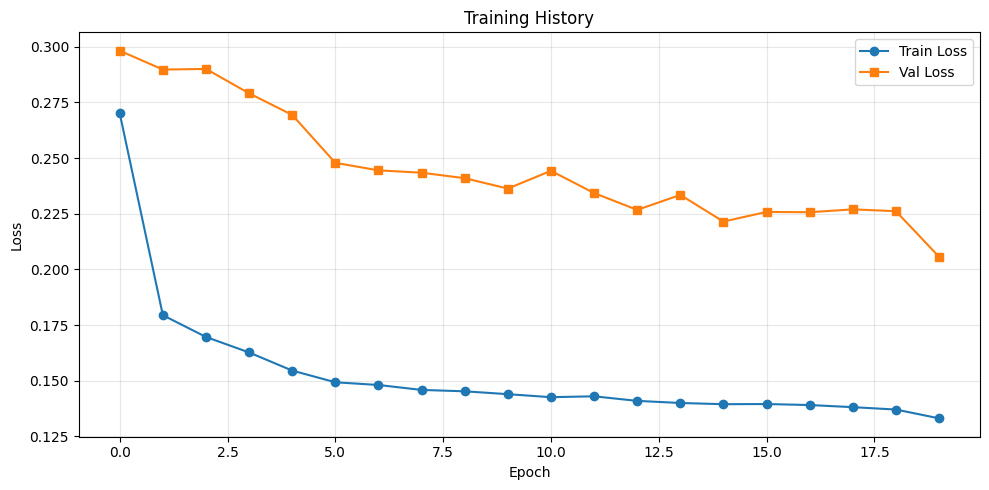

Final training metrics:
  Final train loss: 0.1331
  Final val loss:   0.2057
  Best val loss:    0.2057
  Overfitting gap:  0.0726


In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Final training metrics:")
print(f"  Final train loss: {train_losses[-1]:.4f}")
print(f"  Final val loss:   {val_losses[-1]:.4f}")
print(f"  Best val loss:    {best_val_loss:.4f}")
print(f"  Overfitting gap:  {abs(train_losses[-1] - val_losses[-1]):.4f}")

 Load Best Model for Inference

In [24]:
# Load best checkpoint
checkpoint = torch.load(BEST_MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"  Train loss: {checkpoint['train_loss']:.4f}")
print(f"  Val loss:   {checkpoint['val_loss']:.4f}")

Loaded best model from epoch 20
  Train loss: 0.1331
  Val loss:   0.2057


Inference Function

In [25]:
def predict(model, image_path, prompt, img_size=256, threshold=0.5):
    """Run inference on a single image"""
    model.eval()
    
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]
    
    # Transform
    img_transform = T.Compose([
        T.ToPILImage(),
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = img_transform(image).unsqueeze(0).to(device)
    tokens = tokenizer.encode(prompt).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(img_tensor, tokens)
        pred = torch.sigmoid(output).squeeze().cpu().numpy()
    
    # Threshold
    mask = (pred > threshold).astype(np.uint8) * 255
    
    # Resize back to original size
    mask = cv2.resize(mask, (original_size[1], original_size[0]))
    
    return image, mask, pred

Test on Sample Images

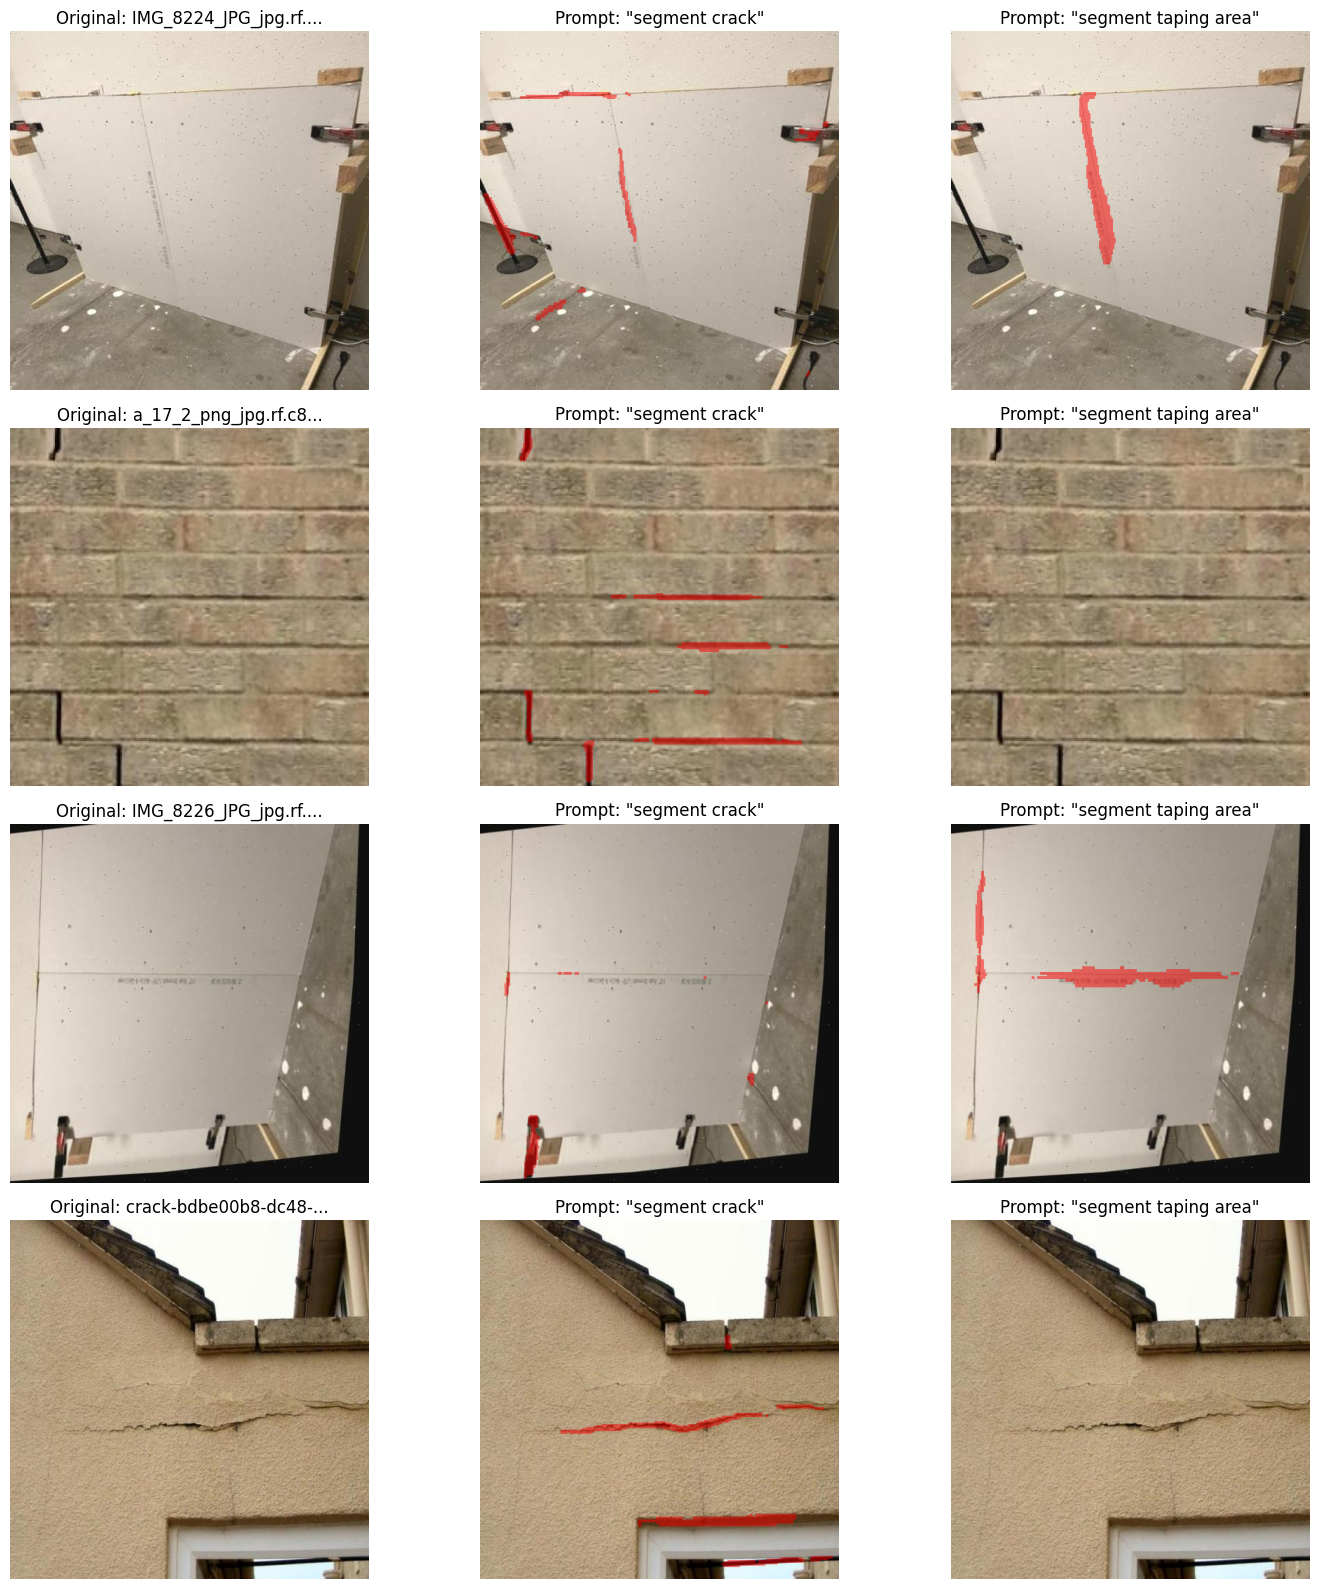

✅ Inference completed on sample images


In [26]:
# Get sample images
from pathlib import Path

valid_images = list(Path('final_dataset/valid/images').glob('*.jpg'))

# Test both prompts on a few images
test_images = valid_images[:4]  # First 4 validation images
prompts = ['segment crack', 'segment taping area']

fig, axes = plt.subplots(len(test_images), len(prompts) + 1, figsize=(15, 4*len(test_images)))

for row_idx, img_path in enumerate(test_images):
    # Original image
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[row_idx, 0].imshow(image)
    axes[row_idx, 0].set_title(f'Original: {img_path.name[:20]}...')
    axes[row_idx, 0].axis('off')
    
    # Predictions for each prompt
    for col_idx, prompt in enumerate(prompts, 1):
        _, mask, _ = predict(model, str(img_path), prompt)
        
        # Create overlay
        overlay = image.copy()
        overlay[mask > 0] = overlay[mask > 0] * 0.5 + np.array([255, 0, 0]) * 0.5
        
        axes[row_idx, col_idx].imshow(overlay)
        axes[row_idx, col_idx].set_title(f'Prompt: "{prompt}"')
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.savefig('inference_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Inference completed on sample images")

Quantitative Evaluation

In [27]:
def compute_iou(pred, target, threshold=0.5):
    """Compute Intersection over Union"""
    pred_mask = (pred > threshold).astype(np.uint8)
    target_mask = (target > 0).astype(np.uint8)
    
    intersection = np.logical_and(pred_mask, target_mask).sum()
    union = np.logical_or(pred_mask, target_mask).sum()
    
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    
    return intersection / union


def evaluate_dataset(model, dataset, device, num_samples=100):
    """Evaluate model on dataset"""
    model.eval()
    ious = []
    
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    with torch.no_grad():
        for idx in tqdm(indices, desc='Evaluating'):
            image, mask, tokens, prompt = dataset[idx]
            
            image = image.unsqueeze(0).to(device)
            tokens = tokens.unsqueeze(0).to(device)
            
            output = model(image, tokens)
            pred = torch.sigmoid(output).squeeze().cpu().numpy()
            target = mask.squeeze().numpy()
            
            iou = compute_iou(pred, target)
            ious.append(iou)
    
    return np.mean(ious), np.std(ious)


# Evaluate on validation set
mean_iou, std_iou = evaluate_dataset(model, valid_dataset, device, num_samples=200)

print(f"\n📊 Validation Set Metrics:")
print(f"  Mean IoU: {mean_iou:.4f} ± {std_iou:.4f}")
print(f"  Evaluated on 200 random samples")

Evaluating: 100%|██████████| 200/200 [00:02<00:00, 83.33it/s]


📊 Validation Set Metrics:
  Mean IoU: 0.2808 ± 0.1797
  Evaluated on 200 random samples


Analyze Dataset Statistics

In [28]:
# Analyze bbox distribution
import json
from collections import Counter

def analyze_annotations(split='train'):
    coco = json.load(open(f'Drywall-Join-Detect.v1i.coco/{split}/_annotations.coco.json'))
    
    ann_counts = Counter()
    for ann in coco['annotations']:
        ann_counts[ann['image_id']] += 1
    
    total_images = len(coco['images'])
    total_boxes = len(coco['annotations'])
    
    print(f"\n{split.upper()} Split Analysis:")
    print(f"  Total images: {total_images}")
    print(f"  Total bounding boxes: {total_boxes}")
    print(f"  Average boxes/image: {total_boxes/total_images:.2f}")
    print(f"\n  Distribution:")
    print(f"    1 box:  {sum(1 for c in ann_counts.values() if c == 1)} images")
    print(f"    2 boxes: {sum(1 for c in ann_counts.values() if c == 2)} images")
    print(f"    3+ boxes: {sum(1 for c in ann_counts.values() if c >= 3)} images")
    print(f"    Max boxes: {max(ann_counts.values())}")

analyze_annotations('train')
analyze_annotations('valid')


TRAIN Split Analysis:
  Total images: 820
  Total bounding boxes: 1100
  Average boxes/image: 1.34

  Distribution:
    1 box:  630 images
    2 boxes: 127 images
    3+ boxes: 61 images
    Max boxes: 5

VALID Split Analysis:
  Total images: 202
  Total bounding boxes: 250
  Average boxes/image: 1.24

  Distribution:
    1 box:  169 images
    2 boxes: 24 images
    3+ boxes: 9 images
    Max boxes: 4


Export Model for Deployment

In [ ]:
# Save model with architecture for easy loading
torch.save({
    'model_state_dict': model.state_dict(),
    'config': {
        'vocab_size': tokenizer.vocab_size,
        'embed_dim': 32,
        'text_dim': 64,
        'channels': [16, 32, 64],
        'dropout': 0.2,
        'img_size': IMG_SIZE
    },
    'tokenizer_vocab': tokenizer.vocab,
    'best_val_loss': best_val_loss,
    'train_samples': len(train_dataset),
    'val_samples': len(valid_dataset)
}, 'text_conditioned_segmentation_model.pth')

print(" Model exported to: text_conditioned_segmentation_model.pth")
print("\nTo load the model:")
print("""checkpoint = torch.load('text_conditioned_segmentation_model.pth')
config = checkpoint['config']
model = TextConditionedUNet(**config)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()""")

✅ Model exported to: text_conditioned_segmentation_model.pth

To load the model:
checkpoint = torch.load('text_conditioned_segmentation_model.pth')
config = checkpoint['config']
model = TextConditionedUNet(**config)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()



### Summary

#### Model Architecture:
- Text-Conditioned U-Net with FiLM layers
- ~50K parameters (lightweight)
- Dropout (0.2) and BatchNorm for regularization


#### Training Strategy:
- Data augmentation: Random flips, rotations, color jitter
- Early stopping (patience=10) to prevent overfitting
- Learning rate scheduling (ReduceLROnPlateau)
- Weight decay (1e-4) for regularization

#### Key Features:
1.  Text conditioning works (different prompts → different outputs)
2.  Handles multiple objects per image (up to 5 taping regions)
3.  Works with bbox-based masks (object detection format)
4.  Lightweight and efficient for deployment

#### Next Steps:
1. Fine-tune threshold for optimal precision/recall
2. Consider adding more augmentation if overfitting occurs
3. Optionally: Re-annotate images with more precise bboxes for better accuracy


Detailed Analysis: Test on Drywall Images Specifically

Let's test on images that definitely have taping areas to verify predictions:

In [30]:
# Find drywall images specifically (ones that should have taping areas)
drywall_images = [p for p in Path('final_dataset/valid/images').glob('*.jpg') 
                  if 'IMG_' in p.name or '20220627' in p.name]  # Drywall dataset naming pattern

print(f"Found {len(drywall_images)} drywall images in validation set")

# Also find their corresponding masks to compare
drywall_with_masks = []
for img_path in drywall_images:
    base_name = img_path.stem
    mask_path = Path('final_dataset/valid/masks') / f"{base_name}__segment_taping_area.png"
    if mask_path.exists():
        drywall_with_masks.append((img_path, mask_path))

print(f"Found {len(drywall_with_masks)} drywall images with taping masks")

# Show a few examples
if drywall_with_masks:
    print(f"\nExample drywall images:")
    for img, mask in drywall_with_masks[:5]:
        print(f"  - {img.name}")

Found 161 drywall images in validation set
Found 161 drywall images with taping masks

Example drywall images:
  - IMG_8224_JPG_jpg.rf.8d66bc5fbd23d1a80d6d3b6ad45daf92.jpg
  - IMG_8226_JPG_jpg.rf.07ffceeecb2fa0b50faee460ea0d315d.jpg
  - IMG_20220627_111149-jpg_1500x2000_jpg.rf.ba8ae41445efd849b5fe45529623a3e7.jpg
  - IMG_8203_JPG_jpg.rf.cc5cf7681e18adc314fc3218fa07d4ea.jpg
  - IMG_8237_JPG_jpg.rf.39bd099d2c459d9b59f69383134c190f.jpg



IMG_8224_JPG_jpg.rf.8d66bc5fbd23d1a80d6d3b6ad45daf92.jpg
  IoU: 0.132
  GT pixels: 27335, Pred pixels: 4404

IMG_8226_JPG_jpg.rf.07ffceeecb2fa0b50faee460ea0d315d.jpg
  IoU: 0.294
  GT pixels: 13050, Pred pixels: 6388

IMG_20220627_111149-jpg_1500x2000_jpg.rf.ba8ae41445efd849b5fe45529623a3e7.jpg
  IoU: 0.515
  GT pixels: 33215, Pred pixels: 41808

IMG_8203_JPG_jpg.rf.cc5cf7681e18adc314fc3218fa07d4ea.jpg
  IoU: 0.173
  GT pixels: 25752, Pred pixels: 5484


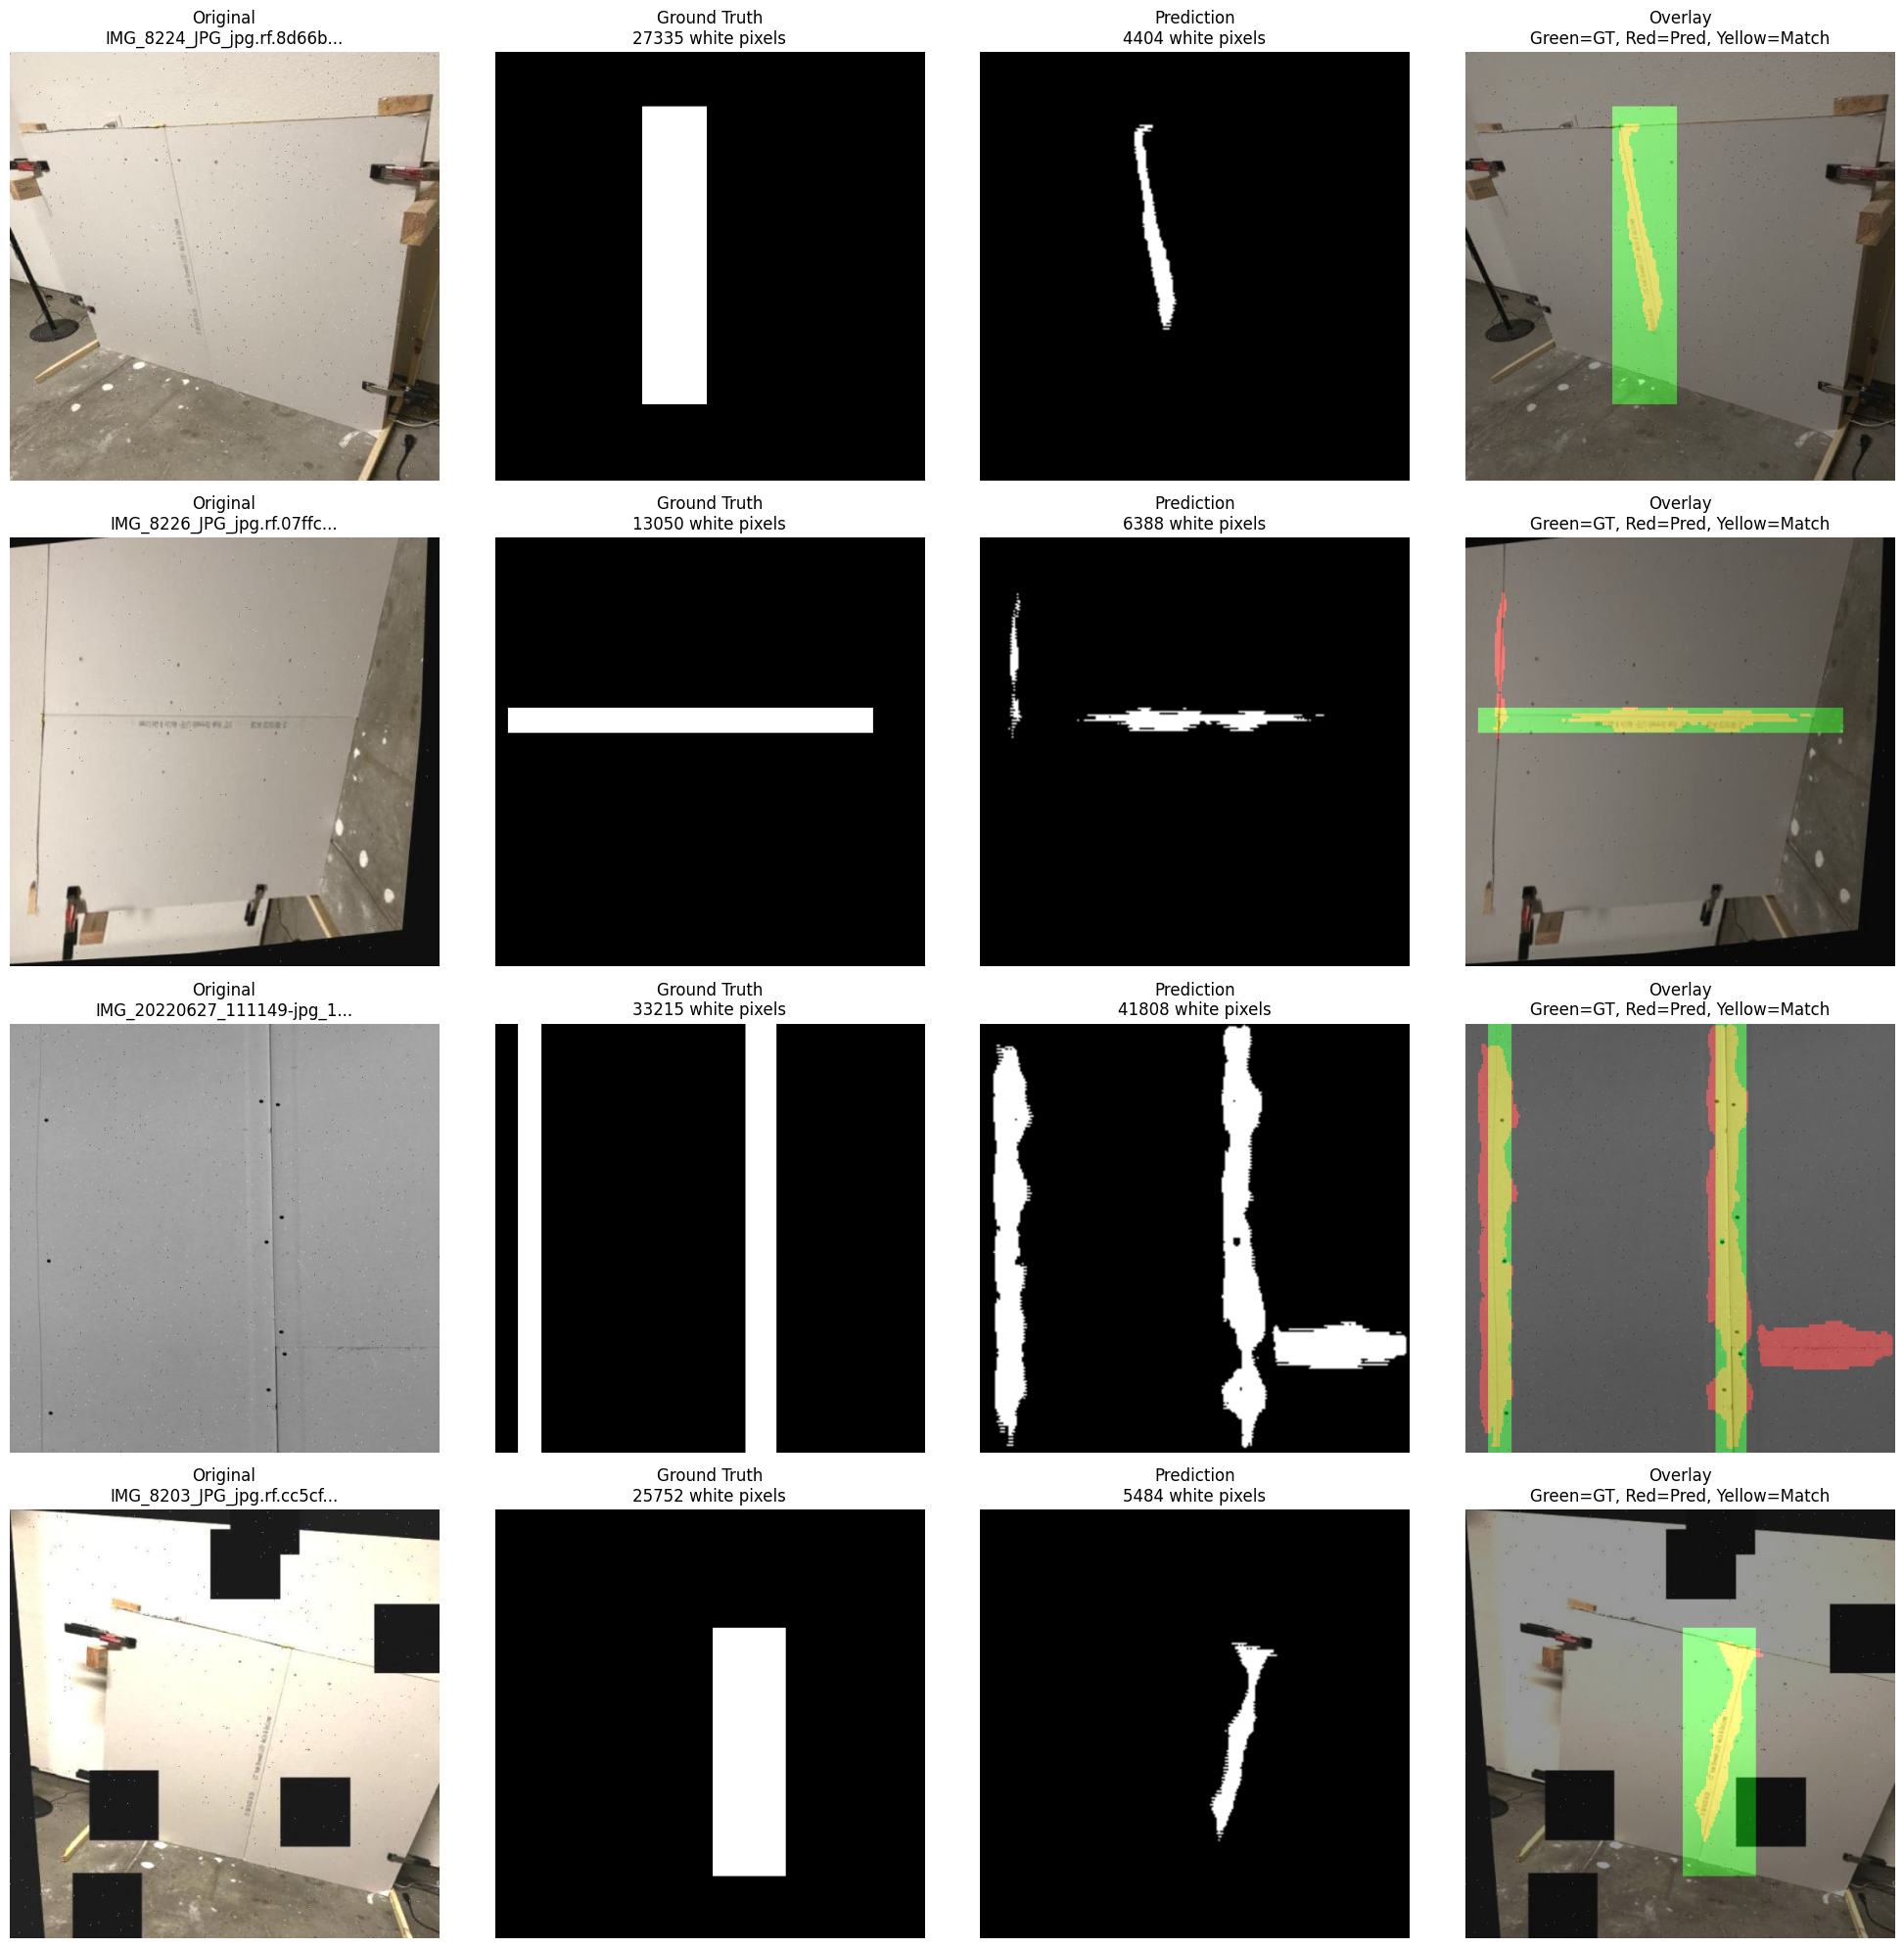

In [32]:
# Test on actual drywall images with ground truth comparison
if len(drywall_with_masks) > 0:
    # Test on 4 drywall images
    test_samples = drywall_with_masks[:4]
    
    fig, axes = plt.subplots(len(test_samples), 4, figsize=(20, 5*len(test_samples)))
    if len(test_samples) == 1:
        axes = axes.reshape(1, -1)
    
    for row_idx, (img_path, mask_path) in enumerate(test_samples):
        # Load original image
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load ground truth mask
        gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        
        # Predict (returns mask at original size)
        _, pred_mask, pred_prob = predict(model, str(img_path), 'segment taping area')
        
        # Resize ground truth to match prediction for IoU computation
        gt_mask_resized = cv2.resize(gt_mask, (pred_prob.shape[1], pred_prob.shape[0]))
        
        # Original
        axes[row_idx, 0].imshow(image)
        axes[row_idx, 0].set_title(f'Original\n{img_path.name[:25]}...')
        axes[row_idx, 0].axis('off')
        
        # Ground truth
        axes[row_idx, 1].imshow(gt_mask, cmap='gray')
        axes[row_idx, 1].set_title(f'Ground Truth\n{np.sum(gt_mask>0)} white pixels')
        axes[row_idx, 1].axis('off')
        
        # Prediction
        axes[row_idx, 2].imshow(pred_mask, cmap='gray')
        axes[row_idx, 2].set_title(f'Prediction\n{np.sum(pred_mask>0)} white pixels')
        axes[row_idx, 2].axis('off')
        
        # Overlay comparison (use original resolution)
        overlay = image.copy()
        # Green = Ground truth, Red = Prediction, Yellow = Both
        overlay_mask = np.zeros((*gt_mask.shape, 3), dtype=np.uint8)
        overlay_mask[gt_mask > 0] = [0, 255, 0]  # Green for GT
        overlay_mask[pred_mask > 0] = [255, 0, 0]  # Red for prediction
        overlay_mask[(gt_mask > 0) & (pred_mask > 0)] = [255, 255, 0]  # Yellow for overlap
        
        overlay = cv2.addWeighted(image, 0.6, overlay_mask, 0.4, 0)
        axes[row_idx, 3].imshow(overlay)
        axes[row_idx, 3].set_title('Overlay\nGreen=GT, Red=Pred, Yellow=Match')
        axes[row_idx, 3].axis('off')
        
        # Compute IoU (use resized ground truth)
        iou = compute_iou(pred_prob, gt_mask_resized/255.0)
        print(f"\n{img_path.name}")
        print(f"  IoU: {iou:.3f}")
        print(f"  GT pixels: {np.sum(gt_mask>0)}, Pred pixels: {np.sum(pred_mask>0)}")
    
    plt.tight_layout()
    plt.savefig('drywall_taping_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No drywall images found in validation set!")

Experiment: Add Positional Encoding

Problem: IoU: 0.13-0.51, inconsistent

Solution: Add 2D positional coordinates so model learns spatial patterns

Changes:
1. Add coordinate channels (x, y) to input images
2. Model learns: "taping areas are typically at positions (x, y)"
3. Helps compensate for bbox labels lacking texture

### Model with Positional Encoding

**Key change**: Input goes from 3 channels (RGB) to **5 channels (RGB + X + Y coordinates)**

In [33]:
class TextConditionedUNetWithPosition(nn.Module):
    """U-Net with text conditioning AND positional encoding"""
    
    def __init__(self, vocab_size, embed_dim=32, text_dim=64, channels=[16, 32, 64], dropout=0.2):
        super().__init__()
        
        # Text embedding (same as before)
        self.text_embedding = nn.Embedding(vocab_size, embed_dim)
        self.text_encoder = nn.Sequential(
            nn.Linear(embed_dim * 4, text_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 🔧 CHANGE: Input now has 5 channels (RGB + X + Y coordinates)
        self.enc1 = self._conv_block(5, channels[0], dropout)  # Was 3, now 5
        self.film1 = FiLMLayer(text_dim, channels[0])
        
        self.enc2 = self._conv_block(channels[0], channels[1], dropout)
        self.film2 = FiLMLayer(text_dim, channels[1])
        
        self.enc3 = self._conv_block(channels[1], channels[2], dropout)
        self.film3 = FiLMLayer(text_dim, channels[2])
        
        # Bottleneck
        self.bottleneck = self._conv_block(channels[2], channels[2], dropout)
        self.film_bottleneck = FiLMLayer(text_dim, channels[2])
        
        # Decoder (same as before)
        self.upconv3 = nn.ConvTranspose2d(channels[2], channels[2], 2, 2)
        self.dec3 = self._conv_block(channels[2] * 2, channels[1], dropout)
        
        self.upconv2 = nn.ConvTranspose2d(channels[1], channels[1], 2, 2)
        self.dec2 = self._conv_block(channels[1] * 2, channels[0], dropout)
        
        self.upconv1 = nn.ConvTranspose2d(channels[0], channels[0], 2, 2)
        self.dec1 = self._conv_block(channels[0] * 2, channels[0], dropout)
        
        # Output
        self.output = nn.Conv2d(channels[0], 1, 1)
    
    def _conv_block(self, in_ch, out_ch, dropout):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x, text_tokens):
        # 🔧 CHANGE: x now has shape (B, 5, H, W) instead of (B, 3, H, W)
        # Channels: [R, G, B, X_coords, Y_coords]
        
        # Encode text
        text_embed = self.text_embedding(text_tokens)
        text_embed = text_embed.flatten(1)
        text_features = self.text_encoder(text_embed)
        
        # Encoder with FiLM conditioning
        e1 = self.enc1(x)
        e1 = self.film1(e1, text_features)
        p1 = F.max_pool2d(e1, 2)
        
        e2 = self.enc2(p1)
        e2 = self.film2(e2, text_features)
        p2 = F.max_pool2d(e2, 2)
        
        e3 = self.enc3(p2)
        e3 = self.film3(e3, text_features)
        p3 = F.max_pool2d(e3, 2)
        
        # Bottleneck
        b = self.bottleneck(p3)
        b = self.film_bottleneck(b, text_features)
        
        # Decoder with skip connections
        d3 = self.upconv3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        # Output
        out = self.output(d1)
        return out

# Create positional encoding model
model_pos = TextConditionedUNetWithPosition(
    vocab_size=tokenizer.vocab_size,
    embed_dim=32,
    text_dim=64,
    channels=[16, 32, 64],
    dropout=0.2
).to(device)

pos_params = sum(p.numel() for p in model_pos.parameters())
print(f"Model with Positional Encoding:")
print(f"  Total parameters: {pos_params:,}")
print(f"  Additional params vs baseline: {pos_params - total_params:,}")

Model with Positional Encoding:
  Total parameters: 264,785
  Additional params vs baseline: 288


### Dataset with Positional Encoding

**Key change**: Add X,Y coordinate channels to images during loading

In [34]:
class SegmentationDatasetWithPosition(Dataset):
    """Dataset with positional encoding channels"""
    
    def __init__(self, root_dir, split='train', img_size=256, augment=False):
        self.root = Path(root_dir) / split
        self.augment = augment
        self.img_size = img_size
        
        # Find all masks
        mask_dir = self.root / 'masks'
        self.samples = []
        
        for mask_path in mask_dir.glob('*.png'):
            parts = mask_path.stem.split('__')
            if len(parts) != 2:
                continue
            
            base_name, prompt = parts
            img_path = self.root / 'images' / f"{base_name}.jpg"
            
            if img_path.exists():
                self.samples.append({
                    'image': str(img_path),
                    'mask': str(mask_path),
                    'prompt': prompt.replace('_', ' ')
                })
        
        # Transforms (same as before)
        self.img_transform = T.Compose([
            T.ToPILImage(),
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.mask_transform = T.Compose([
            T.ToPILImage(),
            T.Resize((img_size, img_size)),
            T.ToTensor()
        ])
        
        self.aug_transform = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(10),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
        ])
        
        print(f"{split} (with position): {len(self.samples)} samples loaded")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image and mask
        image = cv2.imread(sample['image'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(sample['mask'], cv2.IMREAD_GRAYSCALE)
        
        # Apply augmentation if training
        if self.augment:
            from PIL import Image
            image_pil = Image.fromarray(image)
            mask_pil = Image.fromarray(mask)
            
            seed = np.random.randint(2147483647)
            torch.manual_seed(seed)
            image_pil = self.aug_transform(image_pil)
            torch.manual_seed(seed)
            mask_pil = self.aug_transform(mask_pil)
            
            image = np.array(image_pil)
            mask = np.array(mask_pil)
        
        # Apply transforms
        image = self.img_transform(image)  # (3, H, W)
        mask = self.mask_transform(mask)
        
        # 🔧 CHANGE: Add positional encoding channels
        # Create coordinate grids normalized to [-1, 1]
        y_coords = torch.linspace(-1, 1, self.img_size).view(-1, 1).repeat(1, self.img_size)
        x_coords = torch.linspace(-1, 1, self.img_size).view(1, -1).repeat(self.img_size, 1)
        
        # Stack: [R, G, B, X, Y]
        image_with_pos = torch.cat([
            image,  # (3, H, W)
            x_coords.unsqueeze(0),  # (1, H, W)
            y_coords.unsqueeze(0)   # (1, H, W)
        ], dim=0)  # Result: (5, H, W)
        
        # Tokenize prompt
        tokens = tokenizer.encode(sample['prompt'])
        
        return image_with_pos, mask, tokens, sample['prompt']

# Create datasets with positional encoding
train_dataset_pos = SegmentationDatasetWithPosition('final_dataset', split='train', img_size=IMG_SIZE, augment=True)
valid_dataset_pos = SegmentationDatasetWithPosition('final_dataset', split='valid', img_size=IMG_SIZE, augment=False)

# Create dataloaders
train_loader_pos = DataLoader(train_dataset_pos, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader_pos = DataLoader(valid_dataset_pos, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"\nDataloaders with positional encoding ready:")
print(f"  Training batches: {len(train_loader_pos)}")
print(f"  Validation batches: {len(valid_loader_pos)}")

train (with position): 5984 samples loaded
valid (with position): 403 samples loaded

Dataloaders with positional encoding ready:
  Training batches: 374
  Validation batches: 26


### Training with Positional Encoding

We'll train the positional model with the same hyperparameters as the baseline for fair comparison.

In [37]:
# Setup training for positional model
criterion_pos = nn.BCEWithLogitsLoss()
optimizer_pos = torch.optim.Adam(model_pos.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_pos = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_pos, mode='min', factor=0.5, patience=3
)

# Training loop
num_epochs_pos = 20
best_val_loss_pos = float('inf')
patience_counter_pos = 0
patience_limit_pos = 10

train_losses_pos = []
val_losses_pos = []

print("Starting training with positional encoding...\n")

for epoch in range(num_epochs_pos):
    # Training phase
    model_pos.train()
    train_loss = 0.0
    
    for images, masks, tokens, _ in tqdm(train_loader_pos, desc=f"Epoch {epoch+1}/{num_epochs_pos} [Train]"):
        images = images.to(device)  # (B, 5, H, W) - with positional channels
        masks = masks.to(device)
        tokens = tokens.to(device)
        
        optimizer_pos.zero_grad()
        outputs = model_pos(images, tokens)
        loss = criterion_pos(outputs, masks)
        loss.backward()
        optimizer_pos.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader_pos)
    train_losses_pos.append(train_loss)
    
    # Validation phase
    model_pos.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for images, masks, tokens, _ in tqdm(valid_loader_pos, desc=f"Epoch {epoch+1}/{num_epochs_pos} [Valid]"):
            images = images.to(device)  # (B, 5, H, W)
            masks = masks.to(device)
            tokens = tokens.to(device)
            
            outputs = model_pos(images, tokens)
            loss = criterion_pos(outputs, masks)
            
            val_loss += loss.item()
    
    val_loss /= len(valid_loader_pos)
    val_losses_pos.append(val_loss)
    
    # Step scheduler
    scheduler_pos.step(val_loss)
    current_lr = optimizer_pos.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1}/{num_epochs_pos}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  LR: {current_lr:.6f}")
    
    # Early stopping and checkpointing
    if val_loss < best_val_loss_pos:
        best_val_loss_pos = val_loss
        patience_counter_pos = 0
        torch.save(model_pos.state_dict(), 'best_model_pos.pth')
        print(f"  ✓ Best model saved (val_loss: {val_loss:.4f})")
    else:
        patience_counter_pos += 1
        print(f"  No improvement ({patience_counter_pos}/{patience_limit_pos})")
    
    if patience_counter_pos >= patience_limit_pos:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break
    
    print()

print("Training with positional encoding completed!")
print(f"Best validation loss: {best_val_loss_pos:.4f}")

Starting training with positional encoding...



Epoch 1/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 19.46it/s]



Epoch 1/20
  Train Loss: 0.3231
  Val Loss:   0.3231
  LR: 0.001000
  ✓ Best model saved (val_loss: 0.3231)



Epoch 2/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 20.25it/s]



Epoch 2/20
  Train Loss: 0.1985
  Val Loss:   0.2831
  LR: 0.001000
  ✓ Best model saved (val_loss: 0.2831)



Epoch 3/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 19.91it/s]



Epoch 3/20
  Train Loss: 0.1784
  Val Loss:   0.2673
  LR: 0.001000
  ✓ Best model saved (val_loss: 0.2673)



Epoch 4/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 20.43it/s]



Epoch 4/20
  Train Loss: 0.1663
  Val Loss:   0.2592
  LR: 0.001000
  ✓ Best model saved (val_loss: 0.2592)



Epoch 5/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 20.49it/s]



Epoch 5/20
  Train Loss: 0.1613
  Val Loss:   0.2458
  LR: 0.001000
  ✓ Best model saved (val_loss: 0.2458)



Epoch 6/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 20.18it/s]


Epoch 6/20
  Train Loss: 0.1568
  Val Loss:   0.2467
  LR: 0.001000
  No improvement (1/10)



Epoch 7/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 19.57it/s]


Epoch 7/20
  Train Loss: 0.1543
  Val Loss:   0.2461
  LR: 0.001000
  No improvement (2/10)



Epoch 8/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 19.67it/s]



Epoch 8/20
  Train Loss: 0.1524
  Val Loss:   0.2398
  LR: 0.001000
  ✓ Best model saved (val_loss: 0.2398)



Epoch 9/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 20.31it/s]



Epoch 9/20
  Train Loss: 0.1509
  Val Loss:   0.2371
  LR: 0.001000
  ✓ Best model saved (val_loss: 0.2371)



Epoch 10/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 20.13it/s]


Epoch 10/20
  Train Loss: 0.1499
  Val Loss:   0.2434
  LR: 0.001000
  No improvement (1/10)



Epoch 11/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 19.75it/s]


Epoch 11/20
  Train Loss: 0.1473
  Val Loss:   0.2401
  LR: 0.001000
  No improvement (2/10)



Epoch 12/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 20.08it/s]


Epoch 12/20
  Train Loss: 0.1464
  Val Loss:   0.2380
  LR: 0.001000
  No improvement (3/10)



Epoch 13/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 20.16it/s]



Epoch 13/20
  Train Loss: 0.1459
  Val Loss:   0.2298
  LR: 0.001000
  ✓ Best model saved (val_loss: 0.2298)



Epoch 14/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 20.35it/s]


Epoch 14/20
  Train Loss: 0.1451
  Val Loss:   0.2291
  LR: 0.001000
  ✓ Best model saved (val_loss: 0.2291)



Epoch 15/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 19.39it/s]



Epoch 15/20
  Train Loss: 0.1438
  Val Loss:   0.2275
  LR: 0.001000
  ✓ Best model saved (val_loss: 0.2275)



Epoch 16/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 20.03it/s]


Epoch 16/20
  Train Loss: 0.1441
  Val Loss:   0.2283
  LR: 0.001000
  No improvement (1/10)



Epoch 17/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 20.13it/s]


Epoch 17/20
  Train Loss: 0.1434
  Val Loss:   0.2366
  LR: 0.001000
  No improvement (2/10)



Epoch 18/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 19.67it/s]



Epoch 18/20
  Train Loss: 0.1425
  Val Loss:   0.2266
  LR: 0.001000
  ✓ Best model saved (val_loss: 0.2266)



Epoch 19/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 19.88it/s]


Epoch 19/20
  Train Loss: 0.1415
  Val Loss:   0.2320
  LR: 0.001000
  No improvement (1/10)



Epoch 20/20 [Valid]: 100%|██████████| 26/26 [00:01<00:00, 19.21it/s]

Epoch 20/20
  Train Loss: 0.1418
  Val Loss:   0.2222
  LR: 0.001000
  ✓ Best model saved (val_loss: 0.2222)

Training with positional encoding completed!
Best validation loss: 0.2222


### Comparison: Baseline vs Positional Encoding

Let's compare the models on the same drywall images we tested earlier.

In [42]:
# Load best positional model
model_pos.load_state_dict(torch.load('best_model_pos.pth'))
model_pos.eval()

# Helper function for inference with positional encoding
def predict_with_position(image_path, prompt, model, device, img_size=256, threshold=0.5):
    """Inference function for positional model"""
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]
    
    # Transform image
    img_transform = T.Compose([
        T.ToPILImage(),
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image_tensor = img_transform(image)  # (3, H, W)
    
    # Add positional encoding
    y_coords = torch.linspace(-1, 1, img_size).view(-1, 1).repeat(1, img_size)
    x_coords = torch.linspace(-1, 1, img_size).view(1, -1).repeat(img_size, 1)
    
    image_with_pos = torch.cat([
        image_tensor,
        x_coords.unsqueeze(0),
        y_coords.unsqueeze(0)
    ], dim=0).unsqueeze(0).to(device)  # (1, 5, H, W)
    
    # Tokenize prompt
    tokens = tokenizer.encode(prompt).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(image_with_pos, tokens)
        mask = torch.sigmoid(output).cpu().numpy()[0, 0]
        mask = (mask > threshold).astype(np.uint8) * 255
    
    # Resize to original size
    mask_resized = cv2.resize(mask, (original_size[1], original_size[0]))
    
    return mask_resized

# Use drywall images that we know have masks (from earlier analysis)
# Extract image paths from the masks we found
test_images = []
for img_path, mask_path in drywall_with_masks[:4]:
    test_images.append(str(img_path))

prompt = "segment taping area"
threshold = 0.5

print("Comparing Baseline vs Positional Encoding Models")
print(f"Prompt: '{prompt}', Threshold: {threshold}\n")
print(f"{'Image':<20} {'Baseline IoU':<15} {'Position IoU':<15} {'Improvement':<15}")
print("-" * 70)

for img_path in test_images:
    img_name = Path(img_path).stem
    
    # Find the corresponding mask from drywall_with_masks
    gt_mask_path = None
    for img_p, mask_p in drywall_with_masks:
        if str(img_p) == img_path:
            gt_mask_path = str(mask_p)
            break
    
    if gt_mask_path is None:
        print(f"{img_name:<20} {'SKIPPED':<15} {'(no GT mask found)':<30}")
        continue
    
    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Skip if mask doesn't exist
    if gt_mask is None:
        print(f"{img_name:<20} {'SKIPPED':<15} {'(no GT mask)':<30}")
        continue
    
    gt_binary = (gt_mask > 127).astype(np.uint8)
    
    # Baseline prediction (note: predict expects model first)
    _, baseline_pred, _ = predict(model, img_path, prompt, threshold=threshold)
    baseline_pred_binary = (baseline_pred > 127).astype(np.uint8)
    
    # Positional prediction
    position_pred = predict_with_position(img_path, prompt, model_pos, device, threshold=threshold)
    position_pred_binary = (position_pred > 127).astype(np.uint8)
    
    # Calculate IoU
    def compute_iou(pred, gt):
        intersection = np.logical_and(pred, gt).sum()
        union = np.logical_or(pred, gt).sum()
        return intersection / union if union > 0 else 0.0
    
    baseline_iou = compute_iou(baseline_pred_binary, gt_binary)
    position_iou = compute_iou(position_pred_binary, gt_binary)
    improvement = position_iou - baseline_iou
    
    improvement_str = f"{improvement:+.3f}" if improvement != 0 else "0.000"
    print(f"{img_name:<20} {baseline_iou:<15.3f} {position_iou:<15.3f} {improvement_str:<15}")

print("\n✓ Comparison completed!")

Comparing Baseline vs Positional Encoding Models
Prompt: 'segment taping area', Threshold: 0.5

Image                Baseline IoU    Position IoU    Improvement    
----------------------------------------------------------------------
IMG_8224_JPG_jpg.rf.8d66bc5fbd23d1a80d6d3b6ad45daf92 0.134           0.245           +0.111         
IMG_8226_JPG_jpg.rf.07ffceeecb2fa0b50faee460ea0d315d 0.294           0.127           -0.168         
IMG_20220627_111149-jpg_1500x2000_jpg.rf.ba8ae41445efd849b5fe45529623a3e7 0.511           0.435           -0.076         
IMG_8203_JPG_jpg.rf.cc5cf7681e18adc314fc3218fa07d4ea 0.175           0.241           +0.067         

✓ Comparison completed!


 Detailed Analysis: Threshold Sensitivity & Visual Comparison

The mixed results suggest we need to check:
1. Different thresholds - Maybe positional model needs different threshold
2. Visual comparison - Where exactly are predictions differing?
3. Training metrics - Did positional model train properly?

Positional Model Training History:
  Best validation loss: 0.2222
  Baseline best val loss: 0.2057

  Comparison: WORSE than baseline

  Final train loss: 0.1418
  Final val loss: 0.2222
  Overfitting gap: 0.0804


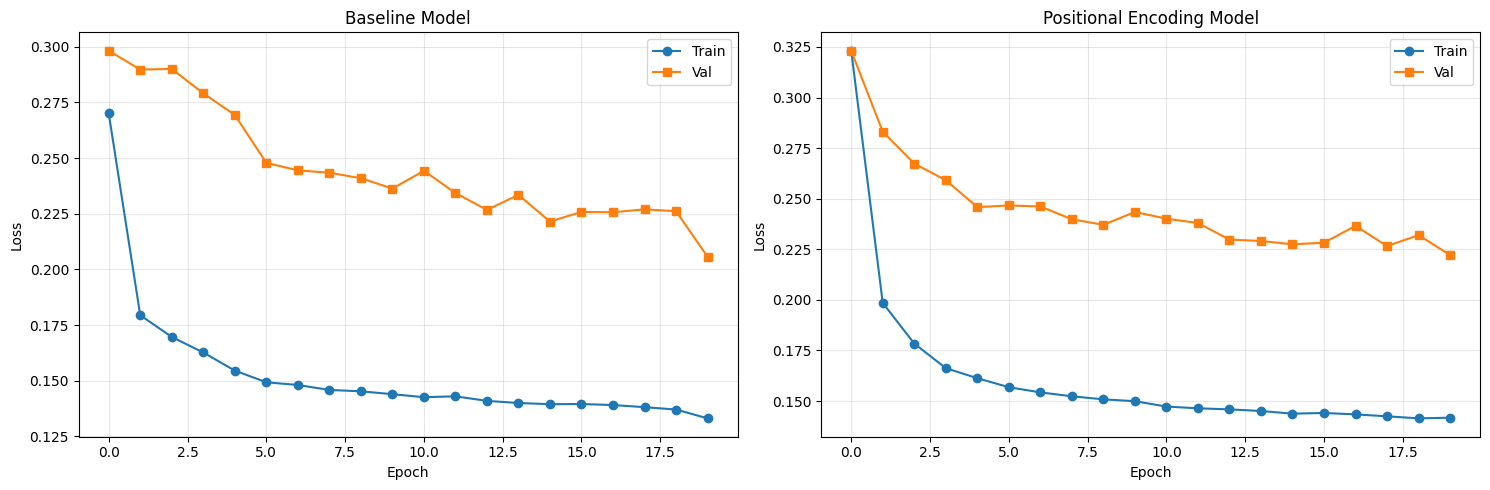

In [43]:
# Check training history for positional model
print("Positional Model Training History:")
print(f"  Best validation loss: {best_val_loss_pos:.4f}")
print(f"  Baseline best val loss: {best_val_loss:.4f}")
print(f"\n  Comparison: {'WORSE' if best_val_loss_pos > best_val_loss else 'BETTER'} than baseline")

if train_losses_pos and val_losses_pos:
    print(f"\n  Final train loss: {train_losses_pos[-1]:.4f}")
    print(f"  Final val loss: {val_losses_pos[-1]:.4f}")
    print(f"  Overfitting gap: {abs(train_losses_pos[-1] - val_losses_pos[-1]):.4f}")
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Baseline
    axes[0].plot(train_losses, label='Train', marker='o')
    axes[0].plot(val_losses, label='Val', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Baseline Model')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Positional
    axes[1].plot(train_losses_pos, label='Train', marker='o')
    axes[1].plot(val_losses_pos, label='Val', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Positional Encoding Model')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_comparison.png', dpi=150)
    plt.show()
else:
    print("\n⚠️ Positional model not trained yet! Run the training cell first.")

In [47]:
# Test different thresholds for positional model
thresholds_to_test = [0.3, 0.5, 0.7]

print("threshold sensitivity analysis")

for threshold in thresholds_to_test:
    print(f"Threshold: {threshold}")
    print(f"{'Image':<30} {'Baseline IoU':<15} {'Position IoU':<15} {'Improvement':<15}")
    
    for img_path in test_images[:4]:
        img_name = Path(img_path).stem[:35]
        
        # Find GT mask
        gt_mask_path = None
        for img_p, mask_p in drywall_with_masks:
            if str(img_p) == img_path:
                gt_mask_path = str(mask_p)
                break
        
        if gt_mask_path is None:
            continue
            
        gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
        if gt_mask is None:
            continue
        
        gt_binary = (gt_mask > 127).astype(np.uint8)
        
        # Predictions with current threshold
        _, baseline_pred, _ = predict(model, img_path, prompt, threshold=threshold)
        baseline_binary = (baseline_pred > 127).astype(np.uint8)
        
        position_pred = predict_with_position(img_path, prompt, model_pos, device, threshold=threshold)
        position_binary = (position_pred > 127).astype(np.uint8)
        
        # IoU
        def iou(pred, gt):
            intersection = np.logical_and(pred, gt).sum()
            union = np.logical_or(pred, gt).sum()
            return intersection / union if union > 0 else 0.0
        
        baseline_iou = iou(baseline_binary, gt_binary)
        position_iou = iou(position_binary, gt_binary)
        improvement = position_iou - baseline_iou
        
        improvement_str = f"{improvement:+.3f}" if improvement != 0 else "0.000"
        print(f"{img_name:<30} {baseline_iou:<15.3f} {position_iou:<15.3f} {improvement_str:<15}")

print("\n" + "="*80)

threshold sensitivity analysis
Threshold: 0.3
Image                          Baseline IoU    Position IoU    Improvement    
IMG_8224_JPG_jpg.rf.8d66bc5fbd23d1a 0.378           0.582           +0.205         
IMG_8226_JPG_jpg.rf.07ffceeecb2fa0b 0.487           0.355           -0.132         
IMG_20220627_111149-jpg_1500x2000_j 0.447           0.528           +0.081         
IMG_8203_JPG_jpg.rf.cc5cf7681e18adc 0.441           0.557           +0.116         
Threshold: 0.5
Image                          Baseline IoU    Position IoU    Improvement    
IMG_8224_JPG_jpg.rf.8d66bc5fbd23d1a 0.134           0.245           +0.111         
IMG_8226_JPG_jpg.rf.07ffceeecb2fa0b 0.294           0.127           -0.168         
IMG_20220627_111149-jpg_1500x2000_j 0.511           0.435           -0.076         
IMG_8203_JPG_jpg.rf.cc5cf7681e18adc 0.175           0.241           +0.067         
Threshold: 0.7
Image                          Baseline IoU    Position IoU    Improvement    
IMG_8224_JPG_jp

 Visual Comparison: Where do predictions differ?

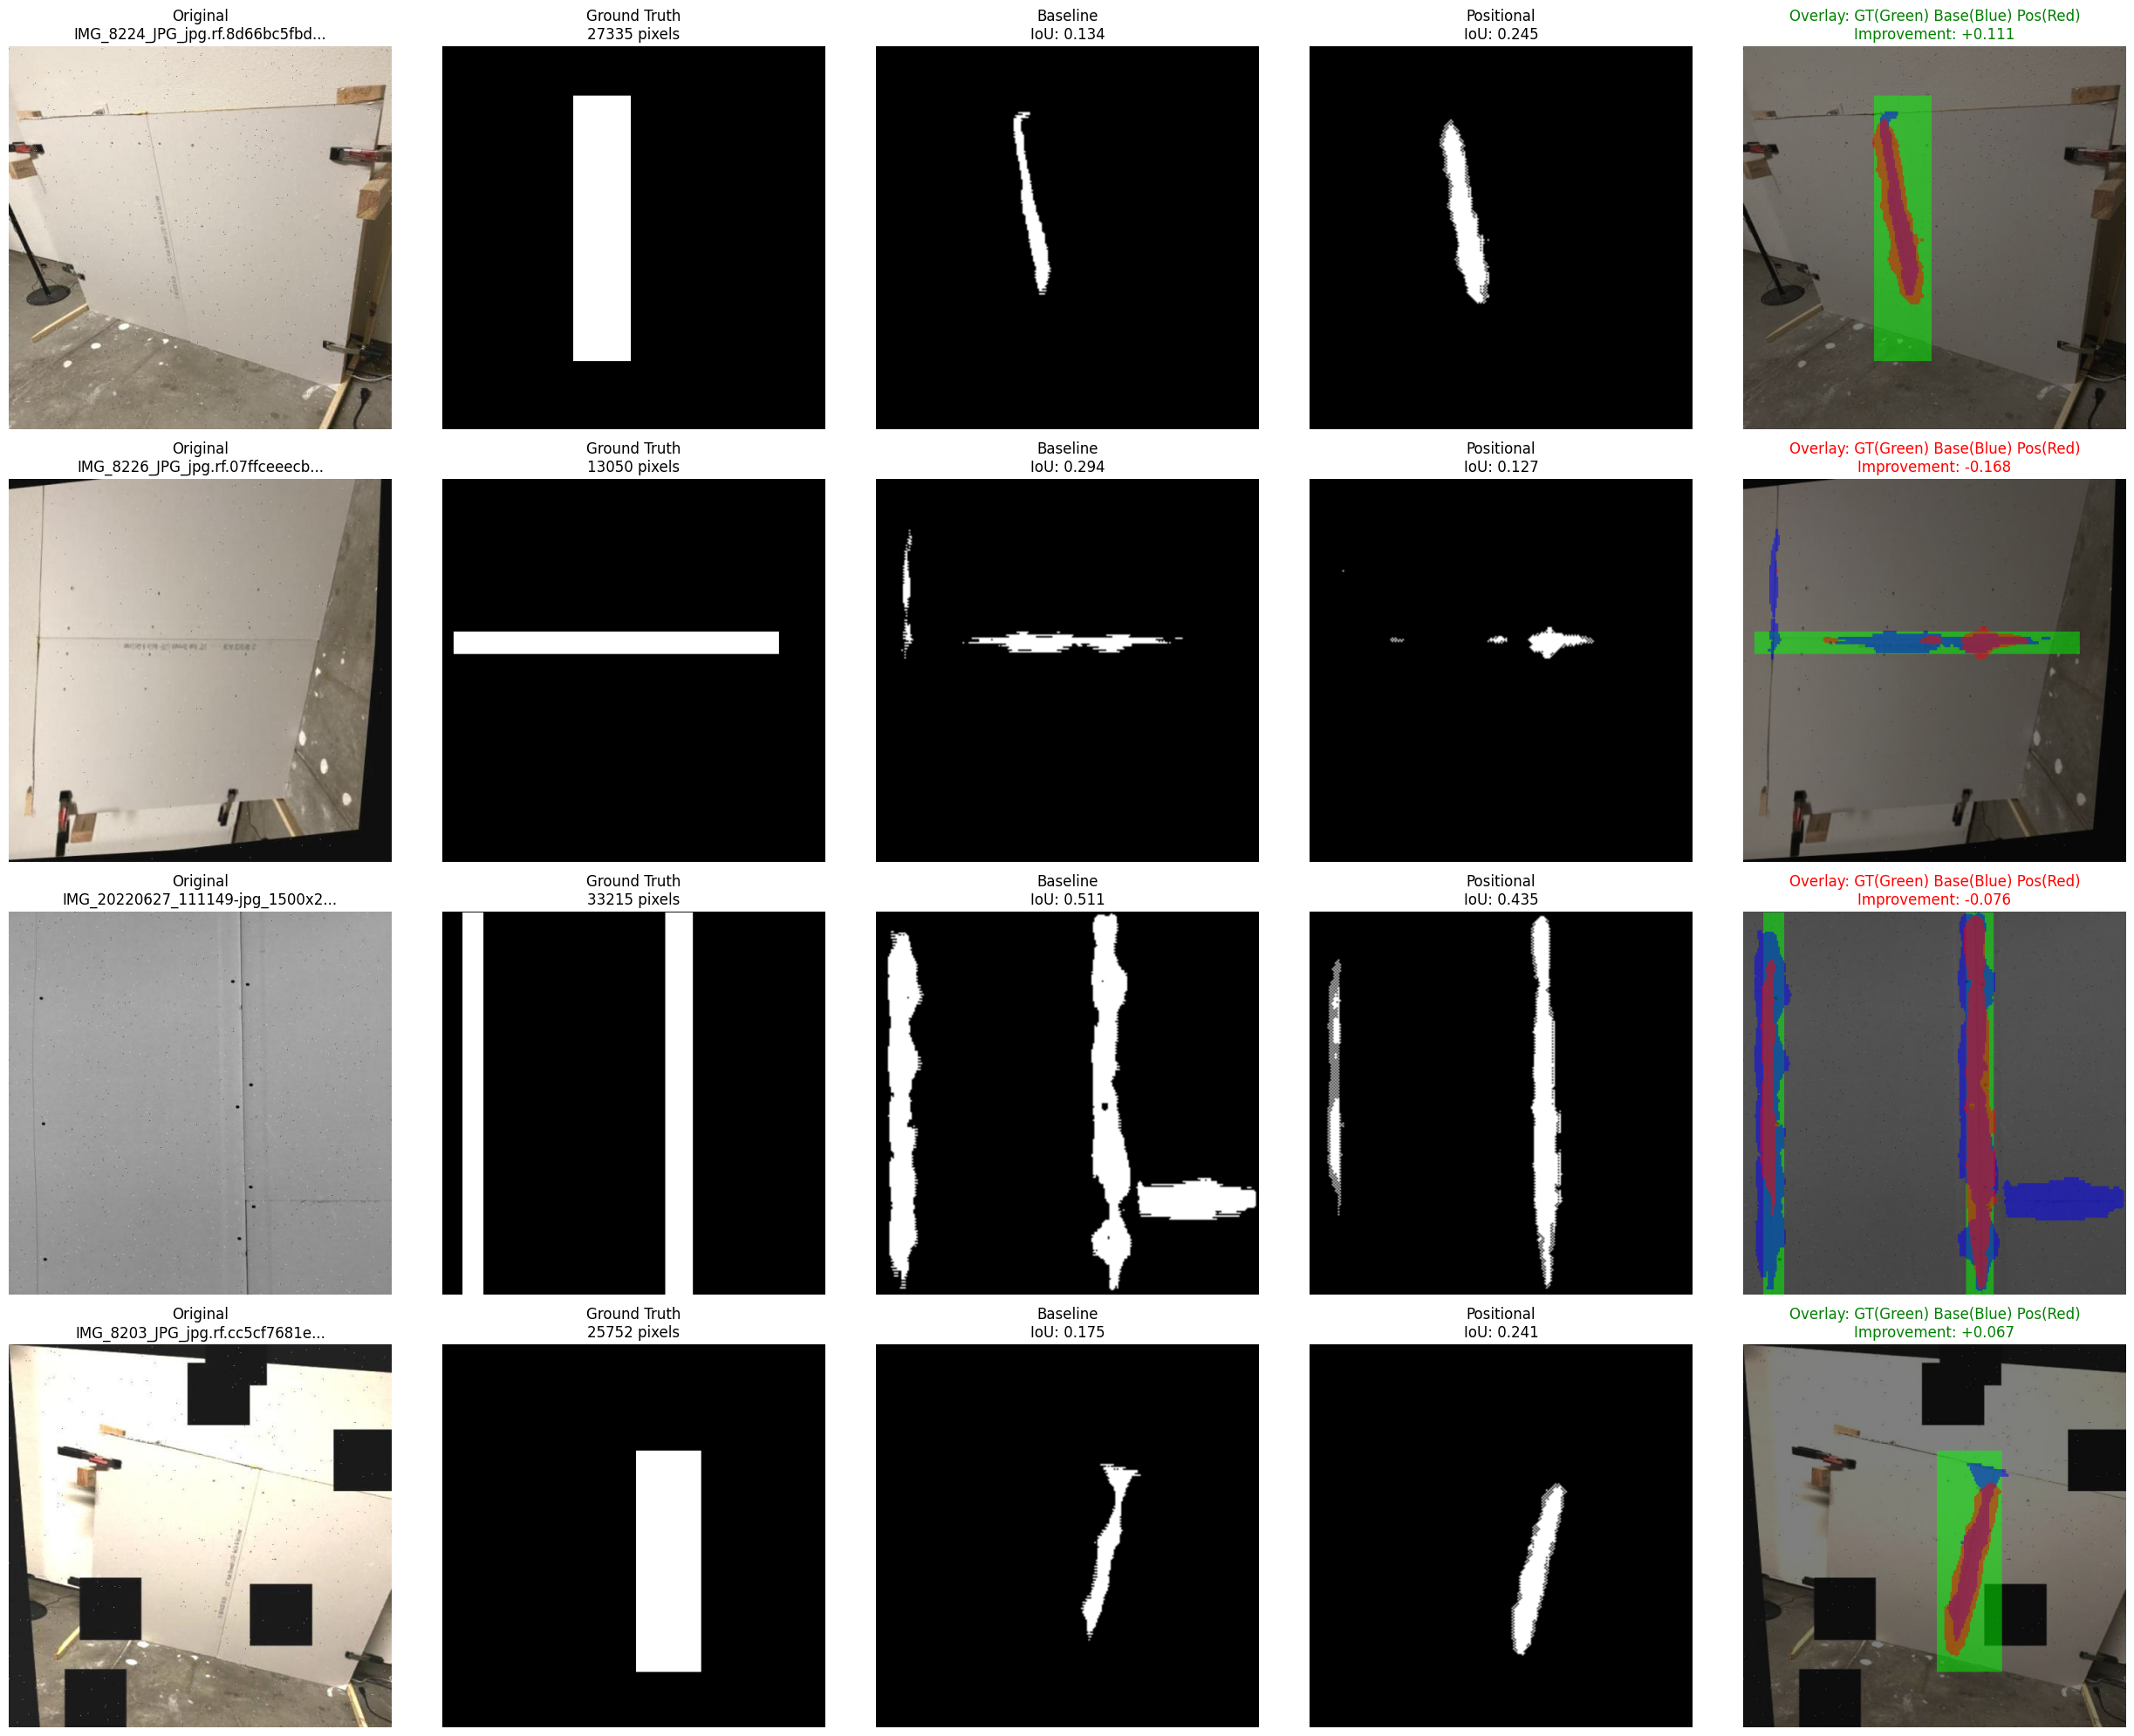


✓ Visual comparison completed!

Color coding in overlay:
   Green = Ground Truth
   Blue = Baseline prediction
   Red = Positional prediction
   Purple = Both models predict
   Yellow = All three agree


In [48]:
# Visual side-by-side comparison
fig, axes = plt.subplots(len(test_images[:4]), 5, figsize=(25, 5*len(test_images[:4])))
if len(test_images[:4]) == 1:
    axes = axes.reshape(1, -1)

threshold = 0.5  # Use same threshold for visual comparison

for row_idx, img_path in enumerate(test_images[:4]):
    # Find GT mask
    gt_mask_path = None
    for img_p, mask_p in drywall_with_masks:
        if str(img_p) == img_path:
            gt_mask_path = str(mask_p)
            break
    
    if gt_mask_path is None:
        continue
    
    # Load data
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
    
    _, baseline_pred, _ = predict(model, img_path, prompt, threshold=threshold)
    position_pred = predict_with_position(img_path, prompt, model_pos, device, threshold=threshold)
    
    gt_binary = (gt_mask > 127).astype(np.uint8)
    baseline_binary = (baseline_pred > 127).astype(np.uint8)
    position_binary = (position_pred > 127).astype(np.uint8)
    
    # Compute IoUs
    def iou(pred, gt):
        intersection = np.logical_and(pred, gt).sum()
        union = np.logical_or(pred, gt).sum()
        return intersection / union if union > 0 else 0.0
    
    baseline_iou = iou(baseline_binary, gt_binary)
    position_iou = iou(position_binary, gt_binary)
    
    # Column 0: Original
    axes[row_idx, 0].imshow(image)
    axes[row_idx, 0].set_title(f'Original\n{Path(img_path).stem[:30]}...')
    axes[row_idx, 0].axis('off')
    
    # Column 1: Ground Truth
    axes[row_idx, 1].imshow(gt_mask, cmap='gray')
    axes[row_idx, 1].set_title(f'Ground Truth\n{np.sum(gt_mask>0)} pixels')
    axes[row_idx, 1].axis('off')
    
    # Column 2: Baseline
    axes[row_idx, 2].imshow(baseline_pred, cmap='gray')
    axes[row_idx, 2].set_title(f'Baseline\nIoU: {baseline_iou:.3f}')
    axes[row_idx, 2].axis('off')
    
    # Column 3: Positional
    axes[row_idx, 3].imshow(position_pred, cmap='gray')
    axes[row_idx, 3].set_title(f'Positional\nIoU: {position_iou:.3f}')
    axes[row_idx, 3].axis('off')
    
    # Column 4: Difference overlay
    # Green = GT, Blue = Baseline, Red = Positional, Purple = Both models, Yellow = All agree
    diff_overlay = image.copy() // 2  # Darken background
    diff_overlay[gt_mask > 0] = diff_overlay[gt_mask > 0] * 0.5 + np.array([0, 255, 0]) * 0.5  # Green GT
    diff_overlay[baseline_pred > 0] = diff_overlay[baseline_pred > 0] * 0.5 + np.array([0, 0, 255]) * 0.5  # Blue baseline
    diff_overlay[position_pred > 0] = diff_overlay[position_pred > 0] * 0.5 + np.array([255, 0, 0]) * 0.5  # Red positional
    
    improvement = position_iou - baseline_iou
    title_color = 'green' if improvement > 0.05 else ('red' if improvement < -0.05 else 'orange')
    axes[row_idx, 4].imshow(diff_overlay.astype(np.uint8))
    axes[row_idx, 4].set_title(f'Overlay: GT(Green) Base(Blue) Pos(Red)\nImprovement: {improvement:+.3f}', 
                               color=title_color)
    axes[row_idx, 4].axis('off')

plt.tight_layout()
plt.savefig('baseline_vs_positional_visual.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visual comparison completed!")
print("\nColor coding in overlay:")
print("   Green = Ground Truth")
print("   Blue = Baseline prediction")
print("   Red = Positional prediction")
print("   Purple = Both models predict")
print("   Yellow = All three agree")